In [12]:
!pip install -U gensim

  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24


In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
spam_data = pd.read_csv('spam_home_kitchen.csv')

In [80]:
spam_data.head()

,Unnamed: 0,Processed Text,class
0,0,recommend great chef test cook cooking tool ea...,1.0
1,1,great pump work perfectly happy purchase thank...,1.0
2,2,beauty function saw pattern online corelle sco...,1.0
3,3,red neck wine glass wonderful use wedding toas...,1.0
4,4,stay away handle body make cheap plastic never...,0.0


In [84]:
class_0 = spam_data[spam_data['class']==0.]
print(len(spam_data))
print(len(class_0))
class_1 = spam_data[spam_data['class']==1.]
print(len(class_1))
class_1 = class_1.sample(n = len(class_0))
print(len(class_1))
class_1

13960
2865
11095
2865


,Unnamed: 0,Processed Text,class
5730,5730,perfect perfect go dip clean easily cover let ...,1.0
9578,9578,nut bolt miss receive package nut bolt miss as...,1.0
12876,12876,lovely cup bought cousin denmark present bioch...,1.0
8029,8029,knew wife bought trash first thought earth wou...,1.0
9832,9832,good small four star size look nice good quali...,1.0
...,...,...,...
7820,7820,like get much faster thought look nice item fi...,1.0
1012,1012,worth price hesitant pay much iron machine one...,1.0
7745,7745,microwave splatter screen use time easy clean ...,1.0
7921,7921,heavy great tad heavy stair stuff great vacuum...,1.0


In [86]:
reb_data = pd.concat((class_0,class_1)).reset_index(drop=True)

In [87]:
X_train = reb_data['Processed Text']
Y_train = reb_data['class']

In [88]:
words_in_sentences=[]
for i in tqdm(x_train):
    words_in_sentences.append(i.split())

100%|███████████████████████████████| 9772/9772 [00:00<00:00, 141704.46it/s]


In [89]:
model = Word2Vec(sentences=words_in_sentences,vector_size = 300)

In [90]:
#Total number of words in the Vocabulary on which the Word2Vec model is trained.
vocab=list(model.wv.key_to_index.keys())
print(len(vocab))

4630


In [91]:
#Average Word2Vec is a technique in which the average of word embeddings of all the words given in a sentence is used as the numerical vector for a given sentence.
def avg_w2vec(sentences):
    transformed=[]
    for sentence in tqdm(sentences):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
        else:
            print(sentence)
    return np.array(transformed)

In [92]:
x_train_transformed=avg_w2vec(x_train)
x_test_transformed=avg_w2vec(x_test)

100%|██████████████████████████████████| 4188/4188 [00:04<00:00, 888.93it/s]


In [93]:
#Using K-Nearest Neighbors Algorithm to predict whether a given review is Spam or not
grid_params = { 'n_neighbors' : [10,20,30,40,50,60],
               'metric' : ['manhattan']}
knn=KNeighborsClassifier()
clf = RandomizedSearchCV(knn, grid_params, random_state=0,n_jobs=-1,verbose=1)
clf.fit(x_train_transformed,y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'metric': ['manhattan'],
                                        'n_neighbors': [10, 20, 30, 40, 50,
                                                        60]},
                   random_state=0, verbose=1)

In [94]:
clf.best_params_

{'n_neighbors': 20, 'metric': 'manhattan'}

In [95]:
clf.best_score_

0.8140603706214808

In [96]:
clf.cv_results_

{'mean_fit_time': array([0.04037681, 0.04377542, 0.04597354, 0.04657407, 0.04717312,
        0.04777169]),
 'std_fit_time': array([0.00119928, 0.00193798, 0.0019989 , 0.00392641, 0.00183226,
        0.00483041]),
 'mean_score_time': array([15.35236478, 15.38234739, 15.69736748, 15.30239429, 15.04254317,
        12.01228704]),
 'std_score_time': array([0.13269666, 0.23038633, 0.2553186 , 0.43303497, 1.31245813,
        0.35125329]),
 'param_n_neighbors': masked_array(data=[10, 20, 30, 40, 50, 60],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
                    'manhattan', 'manhattan'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 10, 'metric': 'manhattan'},
  {'n_neighbors': 20, 'metric': 'manhattan'},
  {'n_neighbors': 30, 'metric':

In [97]:
train_fpr,train_tpr,thresholds=roc_curve(y_train,clf.predict_proba(x_train_transformed)[:,1])
test_fpr,test_tpr,thresholds=roc_curve(y_test,clf.predict_proba(x_test_transformed)[:,1])

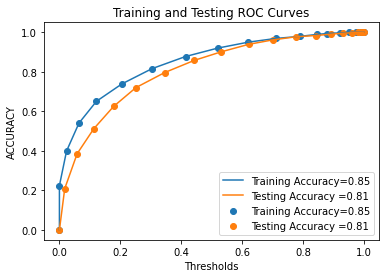

In [98]:

plt.plot(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.plot(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.scatter(train_fpr,train_tpr,label="Training Accuracy="+str(round(auc(train_fpr, train_tpr),2)))
plt.scatter(test_fpr,test_tpr,label="Testing Accuracy ="+str(round(auc(test_fpr, test_tpr),2)))
plt.legend()
plt.xlabel("Thresholds")
plt.ylabel("ACCURACY")
plt.title("Training and Testing ROC Curves")
plt.show()

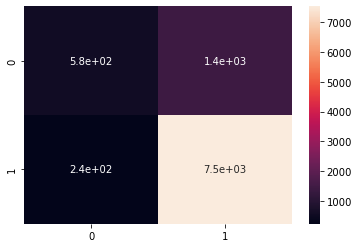

In [99]:
sns.heatmap(confusion_matrix(y_train,clf.predict(x_train_transformed)),annot=True)
plt.show()

In [100]:
print(classification_report(y_train,clf.predict(x_train_transformed)))

              precision    recall  f1-score   support

         0.0       0.70      0.29      0.41      2006
         1.0       0.84      0.97      0.90      7766

    accuracy                           0.83      9772
   macro avg       0.77      0.63      0.65      9772
weighted avg       0.81      0.83      0.80      9772



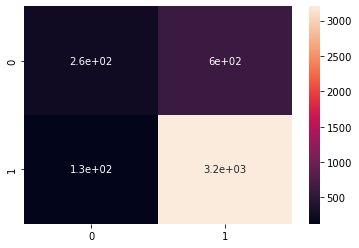

In [101]:
sns.heatmap(confusion_matrix(y_test,clf.predict(x_test_transformed)),annot=True)
plt.show()

In [102]:
print(classification_report(y_test,clf.predict(x_test_transformed)))

              precision    recall  f1-score   support

         0.0       0.67      0.30      0.41       859
         1.0       0.84      0.96      0.90      3329

    accuracy                           0.83      4188
   macro avg       0.75      0.63      0.65      4188
weighted avg       0.81      0.83      0.80      4188

